In [1]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
from generator_functions import random_uni_points_in_ball
from visualizations import plot_avkersize_conv, plot_times_comput, plot_wckersize_conv
from accuracy_bounds.inverseproblems.feasible_sets import compute_feasible_set_linear_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute import worstcase_kernelsize, worstcase_kernelsize_sym, average_kernelsize, average_kernelsize_sym
from accuracy_bounds.inverseproblems.utils import apply_forwardmodel, projection_nullspace_operator
# these need to be tested against analytical values:
from accuracy_bounds.inverseproblems.kersize_compute_dataloader import kersize_samplingYX,feasibleApp_samplingYX_perbatch_cuda,feasibleApp_samplingYX_linear_cuda ,target_distances_samplingYX_precomputedFA_cuda_V2, avgLB_samplingYX
from accuracy_bounds.inverseproblems.utils import torch_sparse_to_scipy_csr, torch_csr_to_scipy


# Tests

## Toy example 1 : 3D ball

In [2]:

# Toy example 1
num_points = 200
radius = 2
center = (0,0,0)
dim = 3
epsilon=1e-1
seed = 43

# Toy forward operator
A = np.diag([1, 1, 0])  # Transformation matrix


target_data = random_uni_points_in_ball(num_points=num_points, radius=radius+epsilon, center=center, dim=3)   
input_data = apply_forwardmodel(A, target_data)



#analytical wc kersize for ball around 0 with radius r+epsilon
wc_kernel_size_analytical = 2*radius+2*epsilon
#analytical av kersize for ball around 0 with radius r+epsilon sampled with uniform distribution
av_kernel_size_analytical = np.multiply((radius+epsilon),np.power(1/3,1/2))

# Distance measure
p_1=2
p_2=2
# Kernel Size order
p=2



# Set the range of k values
max_k = 100
input_target_pairs = 200

# Step 1: Compute feasible sets from the linear forward model and data:
feasible_sets_list = []
for y in input_data[:input_target_pairs]:
    feas_set_y = compute_feasible_set_linear_forwardmodel(A, y, target_data[:input_target_pairs], p_2, epsilon)
    feasible_sets_list.append(feas_set_y)

### Worst case Kersize with symetric assumption, without parallelization

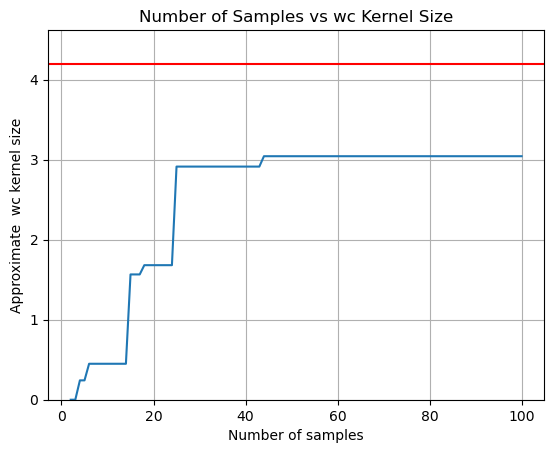

Total Max Kernel Size: 3.043878501427166
Analytical Kernel Size: 4.2
Relative Error: -0.2752670234697224


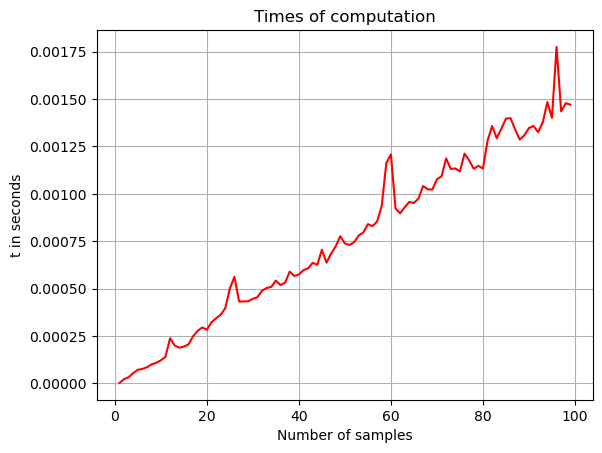

The last kernel size computation took 0.001470 seconds


In [3]:
# Step 2: Compute worst-case kernel sizes:
worstcase_kersize = worstcase_kernelsize(feasible_sets_list, p_1, p)

worstcase_kersize_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize =  worstcase_kernelsize(feasible_sets_list[:k], p_1, p)
    worstcase_kersize_list.append(worstcase_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize, worstcase_kersize_list, wc_kernel_size_analytical, np.arange(2, max_k+1))

plot_times_comput(list(range(1,max_k,1)), times_comput)


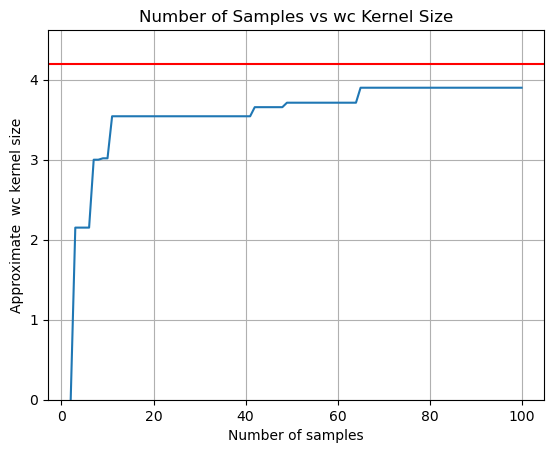

Total Max Kernel Size: 3.899947464924886
Analytical Kernel Size: 4.2
Relative Error: -0.07144107977978904


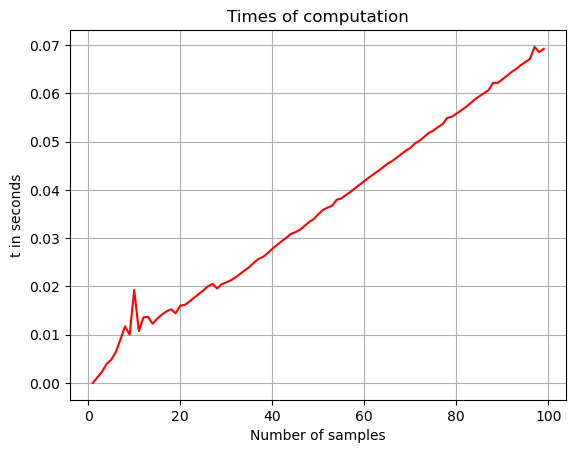

The last kernel size computation took 0.069177 seconds


In [4]:
# Step 2: Compute worst-case kernel sizes with symmetry assumption:
worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:input_target_pairs], target_data, p_1, p_2, p, 2*epsilon)

worstcase_kersize_sym_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    worstcase_kersize_sym_list.append(worstcase_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize_sym, worstcase_kersize_sym_list, wc_kernel_size_analytical, np.arange(2, max_k+1))
plot_times_comput(list(range(1,max_k,1)), times_comput)

### Worst-case kernel size for linear forward model with additive noise, parallelized

In [5]:
batch_size = 50

input_loader1 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
input_loader2 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
target_loader1 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
target_loader2 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False) 

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 50 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


First test the 2 ways of computing feasible appartenance

In [6]:
t0 = time.time()
feas_app_1 = feasibleApp_samplingYX_perbatch_cuda(input_data=input_loader1, forwarded_target= input_loader2, p_Y=2, epsilon=epsilon)
t1 = time.time()
feas_app_2 = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=2, epsilon= epsilon, batchsize=50)
t2 = time.time()

print(f'Per batch : tool {t1-t0:.4f} seconds')
print(f'With candidate selection : {t2-t1:.4f} seconds')


/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:361: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forwarded_target = torch.tensor(forwarded_target, dtype = torch.float32, device = device)
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:362: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data, dtype = torch.float32, device = device)
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:366: UserWarnin

/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Per batch : tool 835.3386 seconds
With candidate selection : 84.3291 seconds


In [7]:
delta = feas_app_1 - feas_app_2.to(dtype=feas_app_1.dtype)
print(f'Difference between the computations {delta.sum()}')

Difference between the computations 0.0


Then, test the worst-case kernel size computation with one of the two feasible appertinance matrix approaches and both precomputed target distances.

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:59<07:58, 59.82s/it]

 22%|██▏       | 2/9 [02:00<07:01, 60.26s/it]

 33%|███▎      | 3/9 [03:03<06:08, 61.46s/it]

 44%|████▍     | 4/9 [04:04<05:06, 61.32s/it]

 56%|█████▌    | 5/9 [05:11<04:14, 63.55s/it]

 67%|██████▋   | 6/9 [06:21<03:16, 65.61s/it]

 78%|███████▊  | 7/9 [07:35<02:16, 68.36s/it]

 89%|████████▉ | 8/9 [08:55<01:12, 72.04s/it]

100%|██████████| 9/9 [10:43<00:00, 71.54s/it]


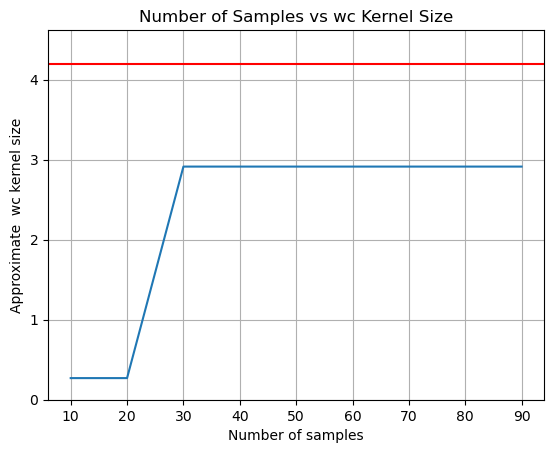

Total Max Kernel Size: 2.9141770537859544
Analytical Kernel Size: 4.2
Relative Error: -0.30614832052715374


In [8]:
max_k = 100
batch_size = 50
wc_kersizes = []
times_comput_FA = []
times_comput_WC = []

for k in tqdm(range(10,max_k,10)):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= 2*epsilon, batchsize = k)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX, feasible_appartenance = target_distances_samplingYX_precomputedFA_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize=k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    wc_kersize_k = kersize_samplingYX(distsXX, feasible_appartenance)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_WC.append(t2-t1)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, wc_kernel_size_analytical, list(range(10,max_k,10)))



### Average kernel size

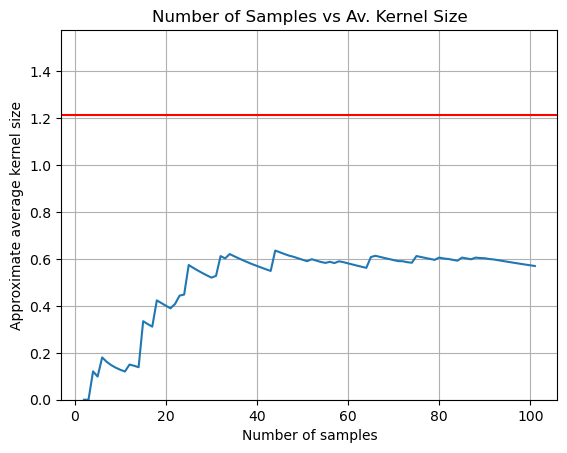

Total Max Kernel Size: 0.5702545261555658
Analytical Kernel Size: 1.2124355652982142
Relative Error: -0.5296619940249737


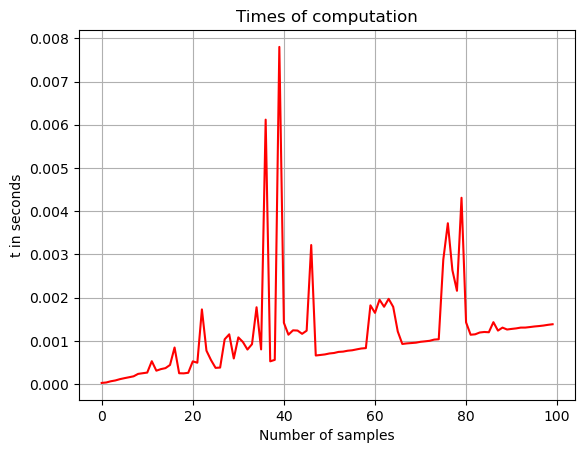

The last kernel size computation took 0.001386 seconds


In [9]:
# Step 2: Compute average kernel sizes:
average_kersize = average_kernelsize(feasible_sets_list, p_1, p)

average_kersize_list = []
times_comput = []
for k in range(0,max_k):
    t0 = time.time()
    average_kersize =  average_kernelsize(feasible_sets_list[:k], p_1, p)
    average_kersize_list.append(average_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize,average_kersize_list, av_kernel_size_analytical, max_k+1)
plot_times_comput(list(range(0,max_k,1)), times_comput)

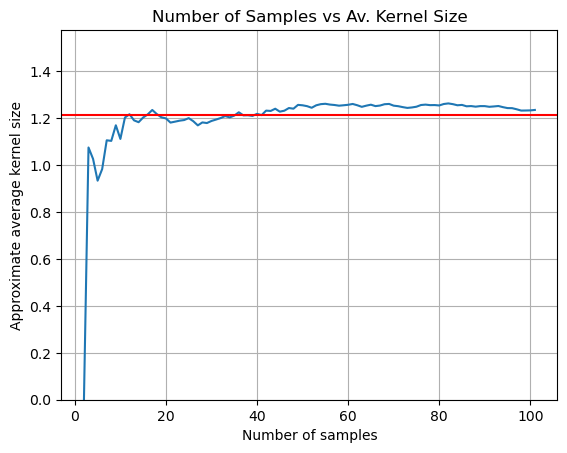

Total Max Kernel Size: 1.2357419986723037
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.01922282226054383


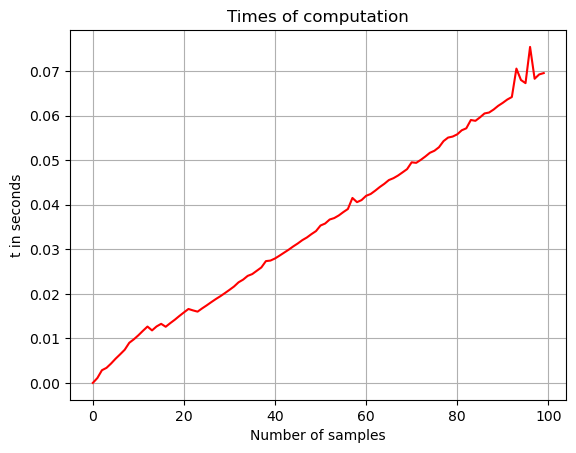

The last kernel size computation took 0.069549 seconds


In [10]:
# Step 2: Compute average symmetric kernel sizes:
average_kersize_sym = average_kernelsize_sym(A, input_data, target_data, p_1, p_2, p, epsilon)

average_kersize_sym_list = []
times_comput = []
for k in range(0,max_k):
    t0 = time.time()
    average_kersize_sym =  average_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    average_kersize_sym_list.append(average_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize_sym,average_kersize_sym_list, av_kernel_size_analytical, max_k+1)
plot_times_comput(list(range(0,max_k,1)), times_comput)

### Average kernel size for linear forward model with additive noise, parallelized

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [01:37<13:00, 97.51s/it]

 22%|██▏       | 2/9 [03:13<11:15, 96.50s/it]

 33%|███▎      | 3/9 [04:25<08:33, 85.63s/it]

 44%|████▍     | 4/9 [05:48<07:01, 84.36s/it]

 56%|█████▌    | 5/9 [07:03<05:24, 81.19s/it]

 67%|██████▋   | 6/9 [08:19<03:57, 79.21s/it]

 78%|███████▊  | 7/9 [09:44<02:42, 81.23s/it]

 89%|████████▉ | 8/9 [11:00<01:19, 79.36s/it]

100%|██████████| 9/9 [12:14<00:00, 81.62s/it]


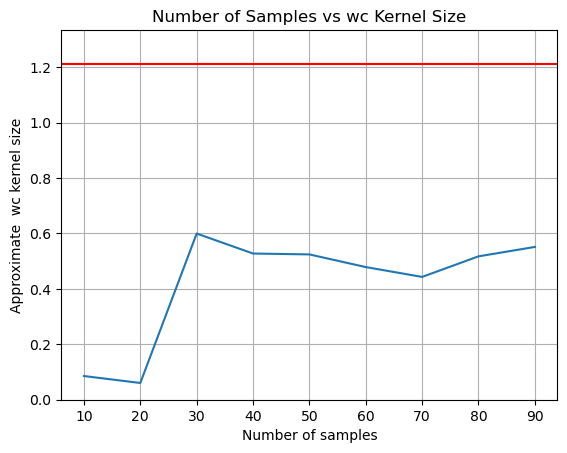

Total Max Kernel Size: 0.5513337972869816
Analytical Kernel Size: 1.2124355652982142
Relative Error: -0.5452675481757466


In [11]:
max_k = 100
batch_size = 50
av_kersizes = []
times_comput_FA = []
times_comput_AV = []

for k in tqdm(range(10,max_k,10)):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= 2*epsilon, batchsize = k)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX, feasible_appartenance = target_distances_samplingYX_precomputedFA_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize=k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    av_kersize_k = avgLB_samplingYX(distsXX, feasible_appartenance, p_X=2)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_WC.append(t2-t1)
    av_kersizes.append(av_kersize_k)

av_kersizef = av_kersizes[-1]

plot_wckersize_conv(av_kersizef, av_kersizes, av_kernel_size_analytical, list(range(10,max_k,10)))